# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nrrd
import numpy as np
import os
import cv2

# Reading the nrrd file

## Reading a single nrrd file

In [3]:
# Function to read and convert nrrd file to grayscale using SimpleITK
def read_grayscale_image_cv2(nrrd_file_path):
    nrrd = sitk.ReadImage(nrrd_file_path)
    # nrrd.GetNumberOfComponentsPerPixel() 
    # For images with scalar or complex pixel types this method returns one
    # For images with a vector pixel type the method returns the number of vector components per pixel
    if nrrd.GetNumberOfComponentsPerPixel() == 1: 
        # if nrrd is Grayscale
        # Gets the numpy array from the nrrd
        image = sitk.GetArrayFromImage(nrrd) 
    else:                                         
        # if nrrd is not Grayscale
        # rescaling the intensity values of the nrrd
        # and casting the pixel type of the rescaled nrrd to [0, 255] range
        nrrd = sitk.Cast(sitk.RescaleIntensity(nrrd), sitk.sitkUInt8)
        # Gets the numpy array from the nrrd
        image = sitk.GetArrayFromImage(nrrd)
    return image

In [4]:
# Read for single nrrd file
nrrd_file_path = 'patients_nrrd/006.nrrd'
grayscale_image_cv2 = read_grayscale_image_cv2(nrrd_file_path)

len(grayscale_image_cv2) # Number of slices contained in the nrrd file

579

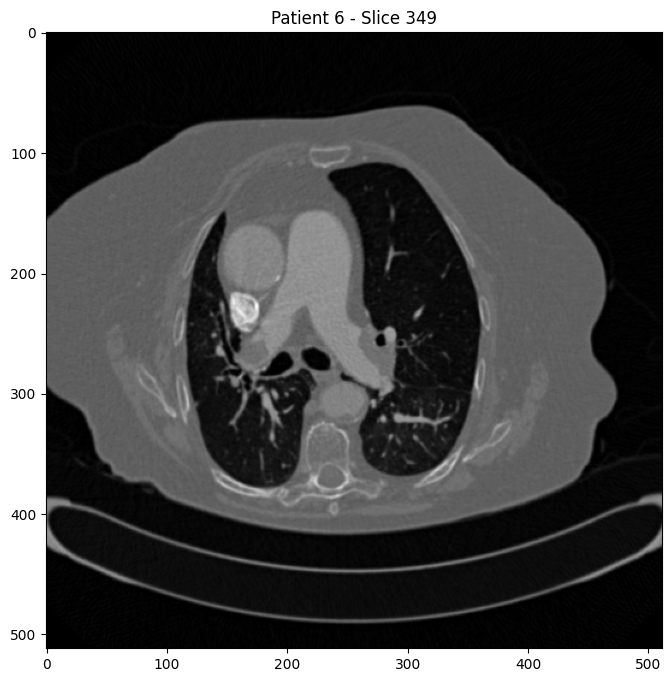

In [5]:
## Showing a single slice from the nrrd file

plt.figure(figsize=(8, 8)) 
plt.imshow(grayscale_image_cv2[349], cmap='gray')
plt.title('Patient 6 - Slice 349')
plt.show()

## Saving the slices from a single nrrd file

### Function to save each slice from an nrrd file

In [6]:
### Applying the default values of medical masking to concentrate in the central aorta depiction
def save_slices(nrrd_file_path, output_folder, lower_bound, upper_bound):
    # Reading the nrrd file
    # nrrd.read(nrrd_file_path) returns data, header
    # header includes a dictionary with information about the nrrd file (type, sizes, encoding)
    data, _ = nrrd.read(nrrd_file_path)
    data_rotated = np.rot90(data, axes=(1, 0))  # Apply rotation

    # If output folder doesn't exists
    if not os.path.exists(output_folder):
        # It is created
        os.makedirs(output_folder)

    # Processing and saving each slice
    for slice_number in range(data_rotated.shape[2]):
        # data_rotated.shape[0] : X dimension
        # data_rotated.shape[1] : Y dimension
        # data_rotated.shape[2] : Number of slices
        # Selecting each slice from the nrrd file
        slice = data_rotated[:, :, slice_number]

        # Applying lower bound threshold
        _, lower_thresh = cv2.threshold(slice, lower_bound, 255, cv2.THRESH_TOZERO)

        # Applying upper bound threshold (inverting the image first)
        inverted_slice = 255 - lower_thresh
        _, upper_thresh_inv = cv2.threshold(inverted_slice, 255 - upper_bound, 255, cv2.THRESH_TOZERO)
        processed_slice = 255 - upper_thresh_inv

        # Saving the processed slice
        plt.imsave(os.path.join(output_folder, f"slice_{slice_number}.png"), processed_slice, cmap='gray')

## Creating slices for patients

### Individually

In [7]:
patient_number = '022'
nrrd_file_path = f'patients_nrrd/{patient_number}.nrrd'
output_folder = f'patient_{patient_number}'
save_slices(nrrd_file_path, output_folder, lower_bound=142-730/2, upper_bound=142+730/2)

### Iteratively

In [8]:
# for i in range(1, 834): # 1st patient number is 1 and last is 833
#     if i < 10:
#         patient_number = f'00{i}'
#         nrrd_file_path = f'../{patient_number}.nrrd'
#         output_folder = f'patient_{patient_number}'
#         save_slices(nrrd_file_path, output_folder, lower_bound=142-730/2, upper_bound=142+730/2)
#         continue
#     if i < 41: # patient numbers stop at 40 and continue after 100
#         patient_number = f'0{i}'
#         nrrd_file_path = f'../{patient_number}.nrrd'
#         output_folder = f'patient_{patient_number}'
#         save_slices(nrrd_file_path, output_folder, lower_bound=142-730/2, upper_bound=142+730/2)
#         continue
#     if i > 100:
#         try: # over 100 numbers not consistent
#             patient_number = f'{i}'
#             nrrd_file_path = f'../e0{patient_number}.nrrd' # After 100, nrrd files are named e0###.nrrd
#             output_folder = f'patient_{patient_number}'
#             save_slices(nrrd_file_path, output_folder, lower_bound=142-730/2, upper_bound=142+730/2)
#         except:
#             continue

-------------------------------------------------------------

-------------------------------------------------------------

# Selecting slices containing the central aorta

## Using the histogram
### Failed for different patients due to:
### different pixel intensities and nrrd file origins (axial magnetic tomography systems/machines)

### Binary Thresholding
#### Failed for diferent patients

In [9]:
patient_number = '006'
image_path = f"patient_{patient_number}/slice_341.png"  # set image path
slice = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

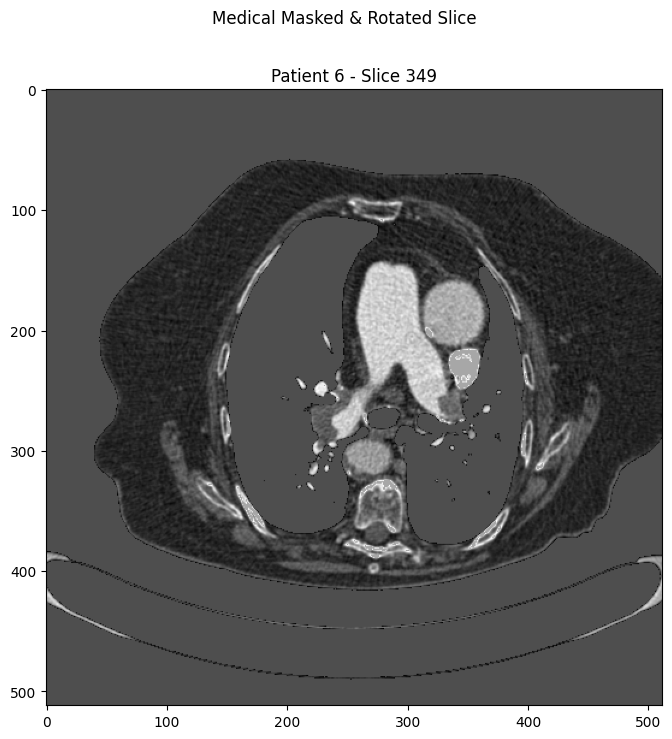

In [10]:
## Showing a single Medical Masked & Rotated slice

plt.figure(figsize=(8, 8))
plt.imshow(slice, cmap='gray')
plt.suptitle('Medical Masked & Rotated Slice')
plt.title('Patient 6 - Slice 349')
plt.show()

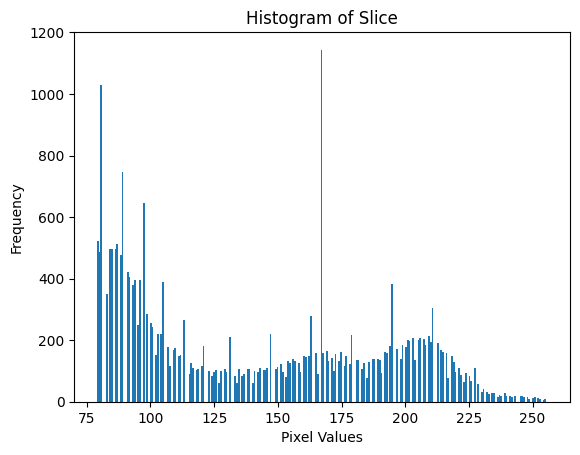

In [11]:
plt.hist(slice.flatten(), 256, [79, 256])
plt.title('Histogram of Slice')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

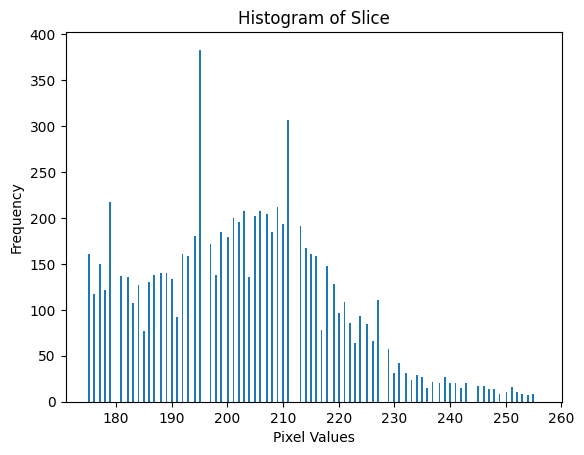

In [12]:
## Reviewing a histogram with different bins
# bins = [175, 256]

plt.hist(slice.flatten(), 256, [175, 256])
plt.title('Histogram of Slice')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

In [13]:
hist, bins = np.histogram(slice, 256, [175,256])
count_over_175 = np.sum(hist)
print(count_over_175)

8203


In [14]:
## After observing the above histogram
## slices containing the central aorta
## contain 8000 pixels of value over 175

slices_list = []

for i in range(578):
    img = cv2.imread(f'patient_006/slice_{i}.png',0)
    hist, bins = np.histogram(img.flatten(), 256, [175,256])
    count_over_175 = np.sum(hist)
    if int(count_over_175) > 8000:
        slices_list.append(i)

In [15]:
# Setting an output folder
# for the processed slices
# based on patient number from above
output_folder = f'patient_{patient_number}_test'
if not os.path.exists(output_folder):
        os.makedirs(output_folder)

for i in slices_list:
    slice = cv2.imread(f'patient_006/slice_{i}.png',0)


    ## Applying binary threshold to the slice
    ## to remove the background
    final_thresh_image,slice_binary=cv2.threshold(slice,115,255,cv2.THRESH_BINARY)


    ## Applying connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(slice_binary)
    # The background is the 1st and largest component
    # hence from stats the 1st compenent is excluded
    # The np.argmax() looks for the index of the largest component excluding the background
    # Therefore the largest component index from stats would be the above +1
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
    # Creating a binary mask of the largest component
    largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

    ## Eroding the largest component

    # The largest component acquired from above
    # could contain the ascending thoracic aorta (not needed)
    # along with the central aorta (need)
    # Eroding the component 
    # and applying another connected components analysis
    # creates a mask of the central aorta

    kernel = np.ones((3, 3), np.uint8)
    eroded_component = cv2.erode(largest_component_mask, kernel, iterations=2)

    ## Connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_component)
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
    largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

    ### Central aorta acquired ###
    #################################################
    ### Mapping the embolism on the central aorta ###


    ## Dilating to include the embolism
    # There is a need to dilate the component 
    # to reverse the previous erosion and
    # to include the embolism that exist on the central aorta.
    dilated_image = largest_component_mask
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)


    ## Extracting the central aorta and its embolism from the slice
    slice_copy = slice.copy()
    slice_copy[dilated_image == 0] = 0

    ## Bluring the central aorta and its embolism
    blurred_aorta = cv2.GaussianBlur(slice_copy,(5,5),0)

    ## to use a more effective band thresholding on the embolism
    ## and create a mask containg the embolisms
    embolism_mask = cv2.inRange(blurred_aorta, 90, 120)

    ## Eroding to remove small particles around the embolism
    ## that went through the band thresholding
    eroded_embolism_component = cv2.erode(embolism_mask, kernel, iterations=1)

    ## Connected components analysis
    ## to keep the 2 largest components
    ## that are the embolisms in both branches of the central aorta
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_embolism_component)
    largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1][:2] + 1

    ## Shaping the first two components mask
    first_two_components_mask = np.zeros_like(labels, dtype=np.uint8)

    ## Identifying the first two components mask
    for index in largest_component_indices:
        first_two_components_mask[labels == index] = 255

    ## Dilating the embolisk mask
    ## to reverse the previous erosion
    embolisms_mask = cv2.dilate(first_two_components_mask, kernel, iterations=2)

    slice_rgb = cv2.cvtColor(slice, cv2.COLOR_GRAY2RGB)

    ## Using red color
    color = (0, 0, 255)  # BGR format (red)

    # Applying the color to the corresponding pixel in the original image
    slice_rgb[embolisms_mask != 0] = color

    ##### Saving the colored/processed slice #####
    cv2.imwrite(f'{output_folder}/slice_{i}_processed.png', slice_rgb)

### Adaptive Thresholding
#### Failed for diferent patients

In [47]:
# def nothing(x):
#     pass

image_path = "patient_006/slice_341.png"  # set image path
slice_341 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# cv2.namedWindow('image')

# cv2.createTrackbar('Block Size', 'image', 9, 1555, nothing)
# cv2.createTrackbar('Constant', 'image', 3, 101, nothing)

# while True:
#     block_size = cv2.getTrackbarPos('Block Size', 'image')
#     constant = cv2.getTrackbarPos('Constant', 'image')

#     is_odd = False
#     if block_size % 2 == 1:
#         is_odd = True

#     # Only update the block size if it's an odd number
#     if is_odd:
#         # Apply adaptive thresholding
#         adaptive_thresholded = cv2.adaptiveThreshold(final_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, constant)

#         cv2.imshow('image', adaptive_thresholded)

#     # Check for ESC key press to exit
#     k = cv2.waitKey(1) & 0xFF
#     if k == 27:
#         break

# cv2.destroyAllWindows()


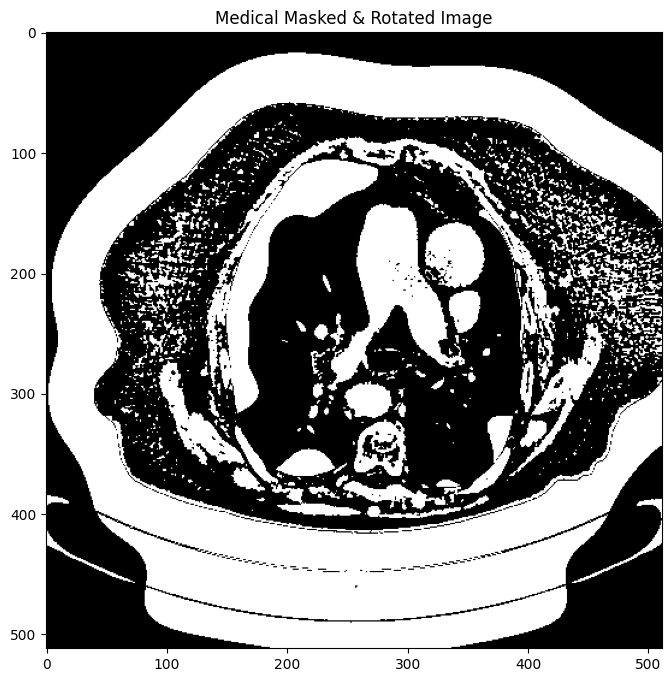

In [48]:
adaptive_thresholded = cv2.adaptiveThreshold(slice_341, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 0)

plt.figure(figsize=(8, 8))
plt.imshow(adaptive_thresholded, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

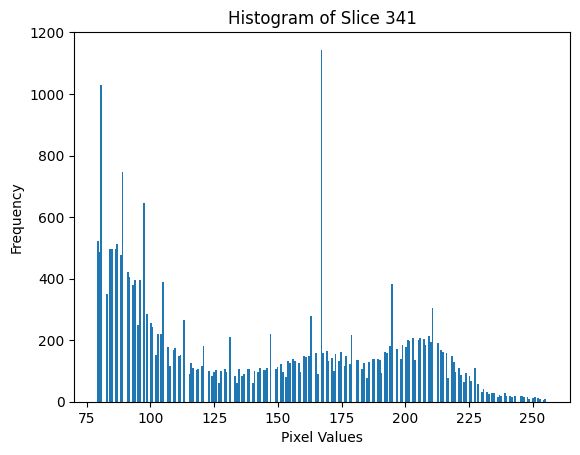

In [49]:
plt.hist(slice_341.flatten(), 256, [79, 256])
plt.title('Histogram of Slice 341')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

## Using the HoughCircles to find the ascending thoracic aorta

In [16]:
slices_list = []


patient_number = '006'

try:
    slices = os.listdir(f'patient_{patient_number}')
except:
    print(f'No slices folder for patient {patient_number}')

for i in range(len(slices)):
    slice = cv2.imread(f'patient_{patient_number}/slice_{i}.png',0)

    ## Apply Gaussian blur
    blurred_slice = cv2.GaussianBlur(slice, (31, 31), 2)
    
    ## Cropping the blurred slice 
    ## to look for the ascending thoracic aorta more efficiently

    # Defining where the cropped slice should start and end
    # because the ascending thoracic aorta appears in the center of the slice 
    start = 0.25
    end = 0.75 

    # Cropping
    cropped = blurred_slice.copy()[int(blurred_slice.shape[1]*(start)):int(blurred_slice.shape[1]*(end-0.15)),
                             int(blurred_slice.shape[0]*(start)):int(blurred_slice.shape[0]*end)]

    ## Detecting circles using HoughCircles
    ## to look for the ascending thoracic aorta
    # While adjusting these parameters for the specific image
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=30, param2=35, minRadius=20, maxRadius=35)

    # If circles are detected,
    # the slice contains the ascending thoracic aorta,
    # append the slice number in the list of slices and draw the circles
    if circles is not None:
        slices_list.append(i)
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(slice, (x, y), r, (0, 255, 0), 4)

### Cropping the slice

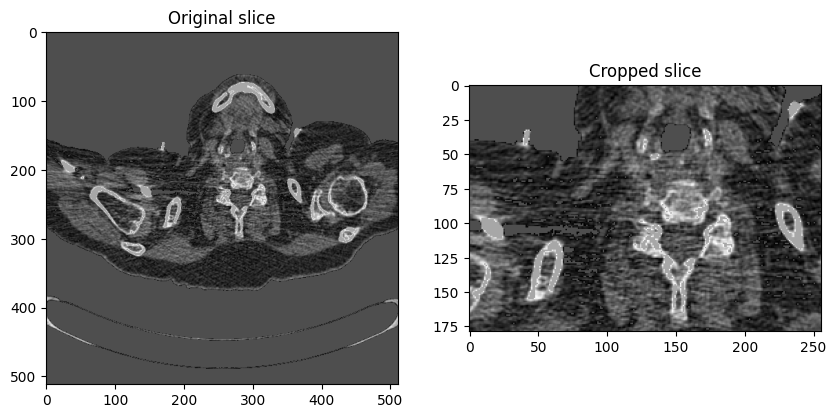

In [17]:
cropped = slice.copy()[int(slice.shape[1]*(start)):int(slice.shape[1]*(end-0.15)),
                       int(slice.shape[0]*(start)):int(slice.shape[0]*end)]
plt.figure(figsize=(10, 10))
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # first subplot
plt.imshow(slice, cmap='gray')
plt.title('Original slice')
plt.subplot(1, 2, 2)  # second subplot
plt.imshow(cropped, cmap='gray')
plt.title('Cropped slice')
plt.show()

### Calibrating circles function

In [18]:
# # Function to update the circle detection whenever trackbars are used
# def detect_circles(x):
#     # Get current trackbar positions
#     dp = cv2.getTrackbarPos('dp', 'Detected Circles')
#     minDist = cv2.getTrackbarPos('minDist', 'Detected Circles')
#     param1 = cv2.getTrackbarPos('param1', 'Detected Circles')
#     param2 = cv2.getTrackbarPos('param2', 'Detected Circles')
#     minRadius = cv2.getTrackbarPos('minRadius', 'Detected Circles')
#     maxRadius = cv2.getTrackbarPos('maxRadius', 'Detected Circles')
    
#     # Detect circles using the current trackbar values
#     circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
#                                param1=param1, param2=param2, 
#                                minRadius=minRadius, maxRadius=maxRadius)
    
#     # Copy the original image to avoid drawing over it
#     displayed_image = image.copy()
    
#     # If circles are detected, draw them
#     if circles is not None:
#         circles = np.round(circles[0, :]).astype("int")
#         for (x, y, r) in circles:
#             cv2.circle(displayed_image, (x, y), r, (0, 255, 0), 4)
    
#     # Display the image with detected circles
#     cv2.imshow('Detected Circles', displayed_image)

# # Load the image from file system
# image_path = "patient_006/slice_341.png"  # set image path
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# # Apply Gaussian blur
# blurred = cv2.GaussianBlur(image, (9, 9), 2)

# # Create a window to attach trackbars
# cv2.namedWindow('Detected Circles')

# # Create trackbars for circle detection parameters
# cv2.createTrackbar('dp', 'Detected Circles', 1, 5, detect_circles)
# cv2.createTrackbar('minDist', 'Detected Circles', 100, 500, detect_circles)
# cv2.createTrackbar('param1', 'Detected Circles', 50, 100, detect_circles)
# cv2.createTrackbar('param2', 'Detected Circles', 30, 100, detect_circles)
# cv2.createTrackbar('minRadius', 'Detected Circles', 0, 100, detect_circles)
# cv2.createTrackbar('maxRadius', 'Detected Circles', 0, 200, detect_circles)

# detect_circles(0)

# cv2.waitKey(0)

# cv2.destroyAllWindows()

# Final Analysis: Patient 6 - Slice 340
# Finding embolisms on the central aorta

## 1st Attempt: Equalisation - Edge detection
### Failed to isolate the central aorta

### Equalisation

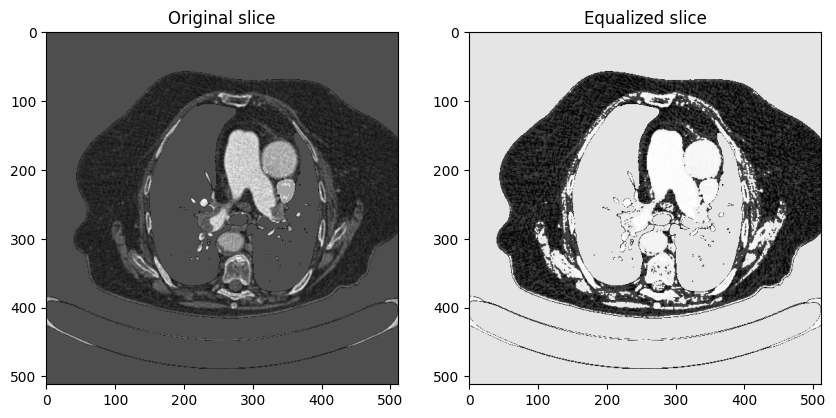

In [19]:
patient = '006'
slice_n = 340

slice_340 = cv2.imread(f'patient_{patient}/slice_{slice_n}.png',0)

# Equalizing the histogram
equalized_slice = cv2.equalizeHist(slice_340)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(slice_340, cmap='gray')
plt.title('Original slice')
plt.subplot(1, 2, 2)
plt.imshow(equalized_slice, cmap='gray')
plt.title('Equalized slice')
plt.show()

### Edge detection

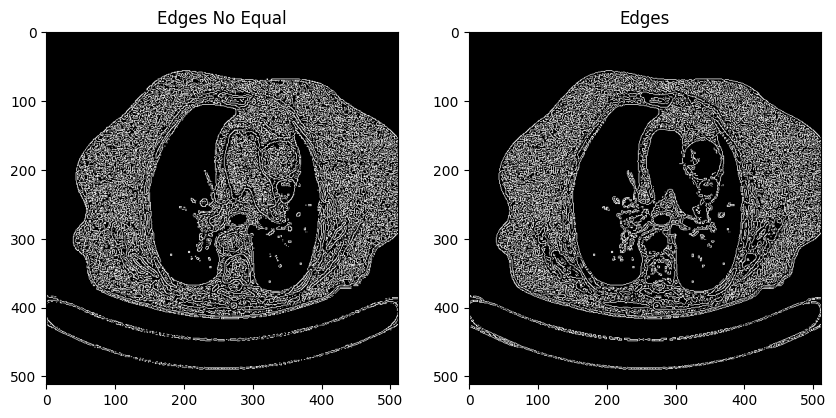

In [20]:
# Edge Detection (using Canny)
# for equalized slice
edges = cv2.Canny(equalized_slice, 10, 50)
# for original slice
edges_no_equal = cv2.Canny(slice_340, 10, 50)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(edges_no_equal, cmap='gray')
plt.title('Edges No Equal')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.show()

## 2nd Attempt
### Successfully isolated the central aorta and identified the embolisms
### (Various tries of parameterization)

### Binary Thresholding

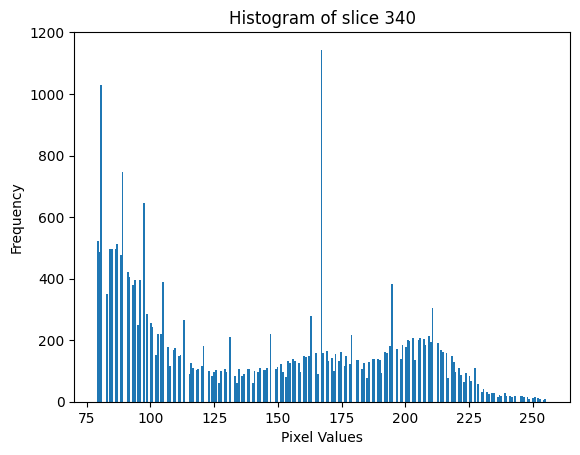

In [21]:
patient = '006'
slice_n = 341

slice_340 = cv2.imread(f'patient_{patient}/slice_{slice_n}.png', cv2.IMREAD_GRAYSCALE)
hist , bins = np.histogram(slice_340.flatten(), 256, [0,256])

plt.hist(slice_340.flatten(), 256, [79, 256])
plt.title('Histogram of slice 340')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

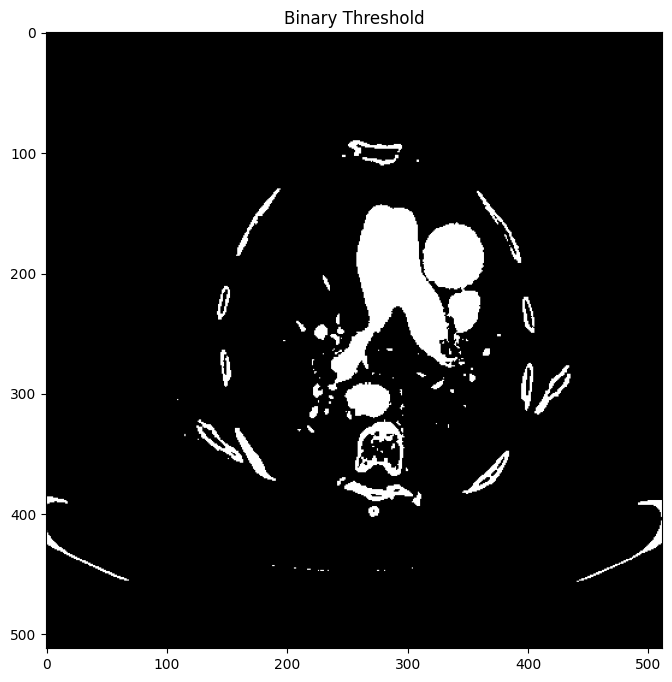

In [22]:
final_thresh_image,thresh=cv2.threshold(slice_340,115,255,cv2.THRESH_BINARY)

plt.figure(figsize=(8, 8))
plt.imshow(thresh, cmap='gray')
plt.title('Binary Threshold')
plt.show()

### Connected Components Analysis

In [23]:
# Find the largest non-black component
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
print('largest_component_index: ', largest_component_index)

largest_component_index:  7


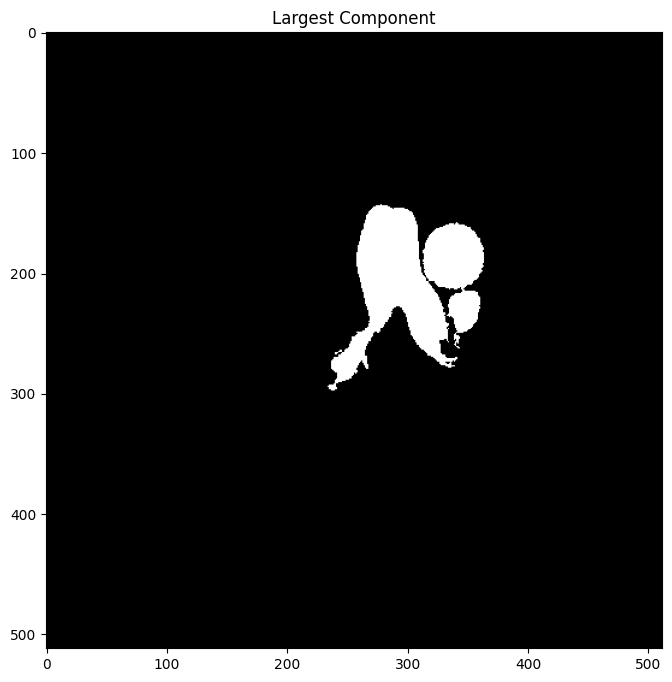

In [24]:
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

plt.figure(figsize=(8, 8))
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Largest Component')
plt.show()

### Erosion

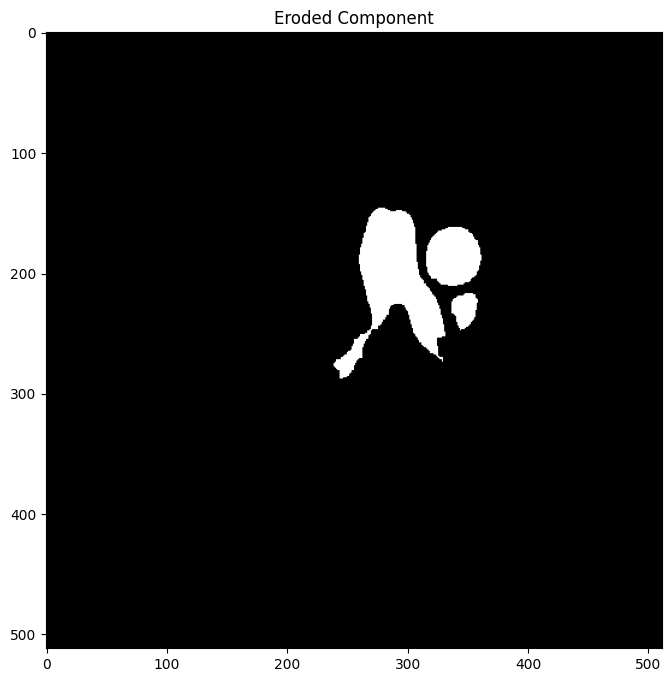

In [25]:
kernel = np.ones((3, 3), np.uint8)


eroded_component = cv2.erode(largest_component_mask, kernel, iterations=2)

plt.figure(figsize=(8, 8))
plt.imshow(eroded_component, cmap='gray')
plt.title('Eroded Component')
plt.show()

### Conected Components Analysis

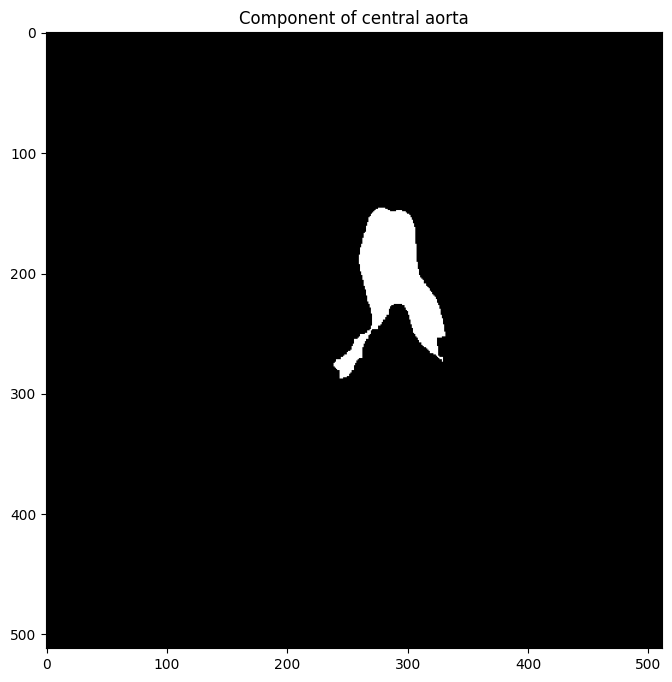

In [26]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_component)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

plt.figure(figsize=(8, 8)) 
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Component of central aorta')
plt.show()

### Dialation

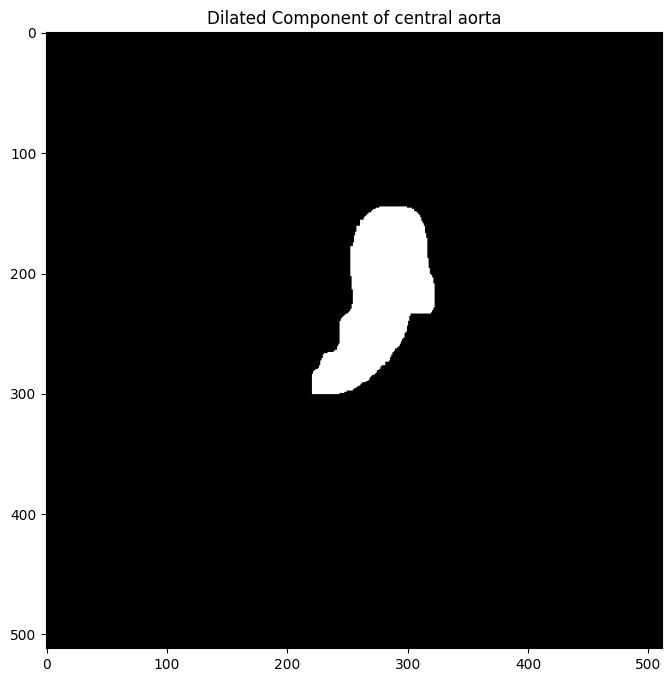

In [27]:
#kernel = np.ones((5, 5), np.uint8)
kernel = np.ones((3, 3), np.uint8)

dilated_component = cv2.dilate(largest_component_mask, kernel, iterations=8)


plt.figure(figsize=(8, 8))
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Component of central aorta')
plt.show()

### Masking the central aorta on the original slice

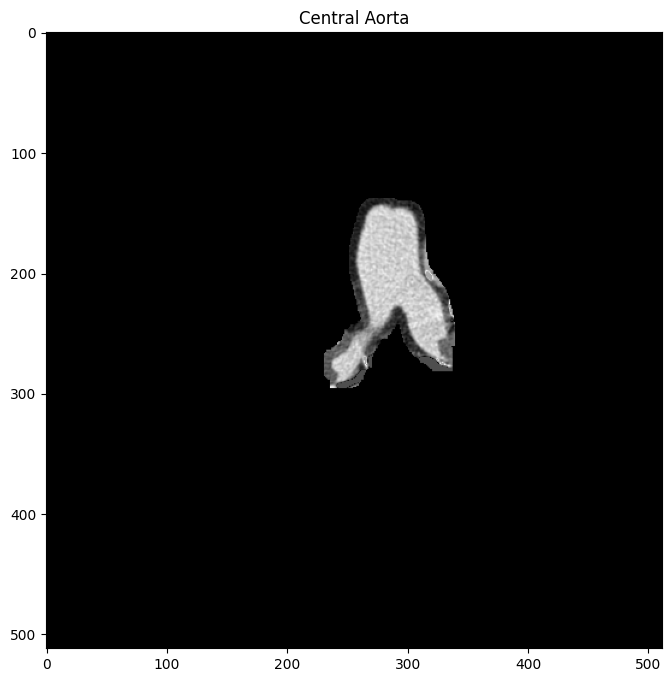

In [28]:
slice_copy_1 = slice_340.copy()
slice_copy_1[dilated_component == 0] = 0

plt.figure(figsize=(8, 8))
plt.imshow(slice_copy_1, cmap='gray')
plt.title('Central Aorta')
plt.show()


### Attempt 1: to find the embolism on the central aorta

#### Observing the histogram

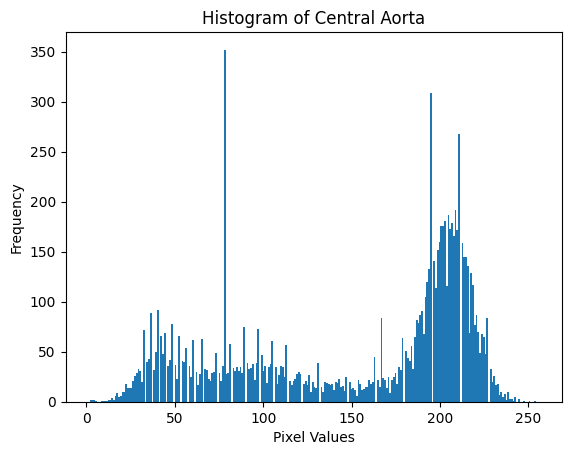

In [29]:
central_aorta = slice_copy_1

plt.hist(central_aorta.flatten(), 256, [1, 256])
plt.title('Histogram of Central Aorta')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

####  Blurring
##### to use a more effective band thresholding on the embolism
##### and create a mask containg the embolisms

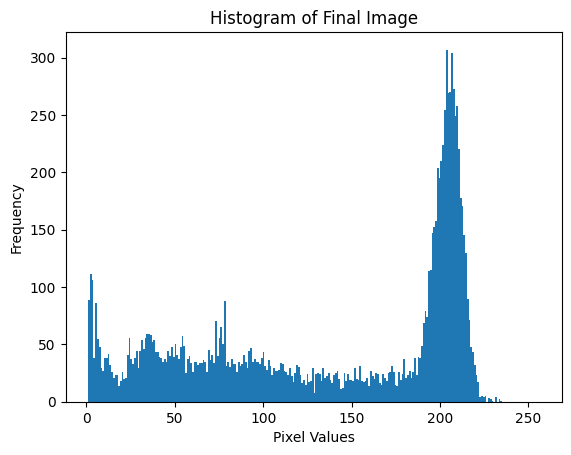

In [30]:
blurred_central_aorta = cv2.GaussianBlur(central_aorta,(5,5),0)

plt.hist(blurred_central_aorta.flatten(), 256, [1, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

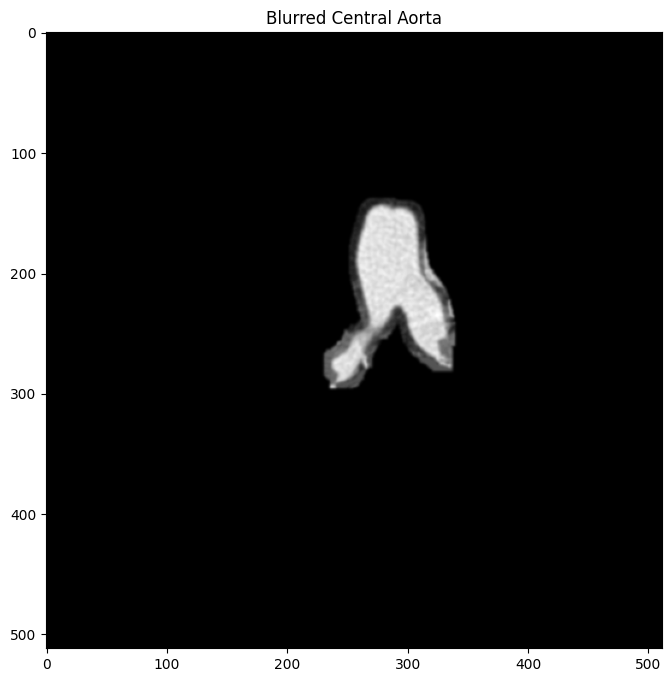

In [31]:
plt.figure(figsize=(8, 8))
plt.imshow(blurred_central_aorta, cmap='gray')
plt.title('Blurred Central Aorta')
plt.show()

#### Band Thresholding

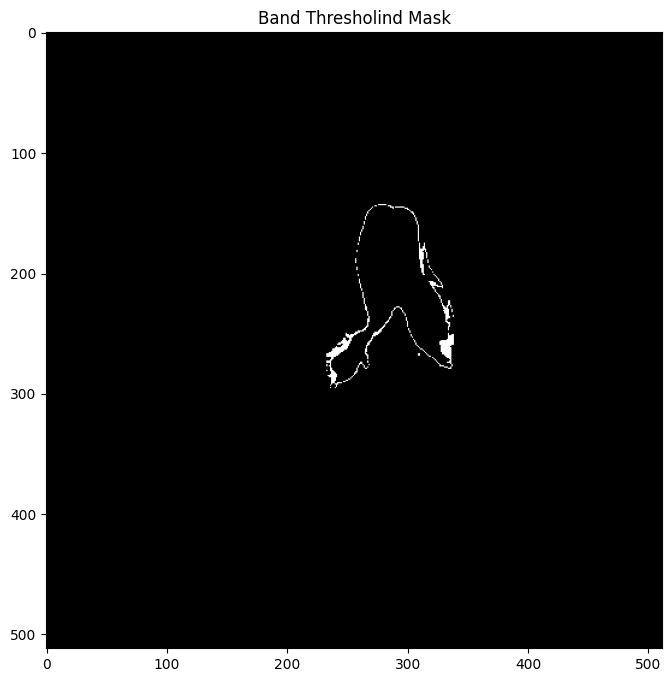

In [32]:
mask = cv2.inRange(blurred_central_aorta, 90, 120)

plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('Band Thresholind Mask')
plt.show()

#### Erosion
##### Eroding to remove small particles around the embolism
##### that went through the band thresholding

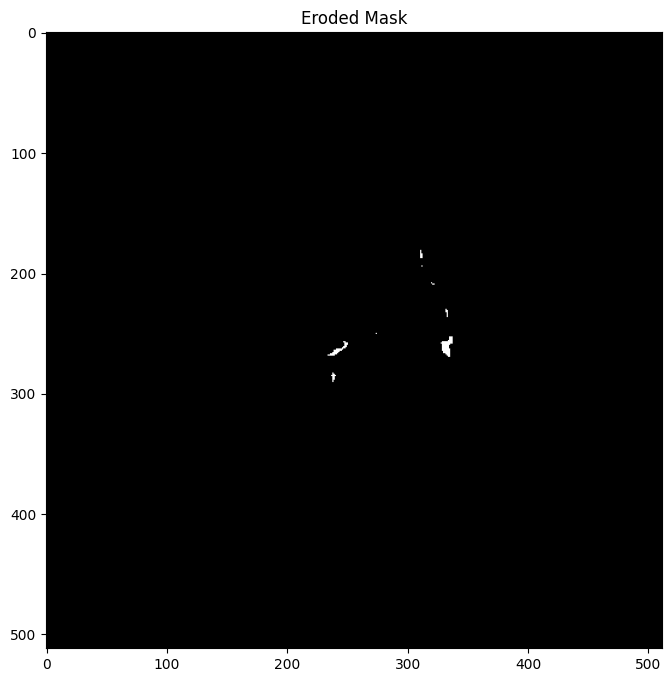

In [33]:
eroded_mask = cv2.erode(mask, kernel, iterations=1)

plt.figure(figsize=(8, 8))
plt.imshow(eroded_mask, cmap='gray')
plt.title('Eroded Mask')
plt.show()

#### Connected components analysis
##### to keep the 2 largest components (the embolisms)
##### Failed on other patients. We only keep the largest component on the main.ipynb

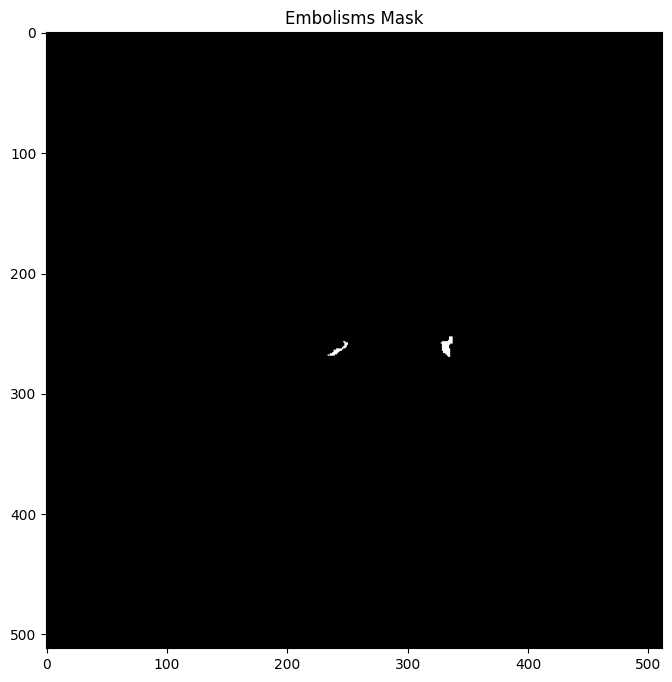

In [34]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_mask)
largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1][:2] + 1
first_two_components_mask = np.zeros_like(labels, dtype=np.uint8)
for index in largest_component_indices:
    first_two_components_mask[labels == index] = 255

plt.figure(figsize=(8, 8))
plt.imshow(first_two_components_mask, cmap='gray')
plt.title('Embolisms Mask')
plt.show()

#### Dilating the embolism mask
##### to reverse the previous erosion

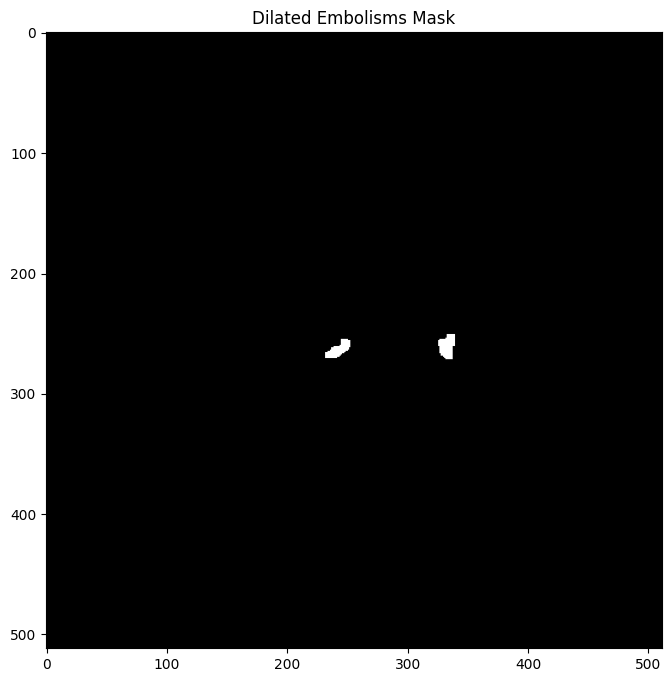

In [35]:
#kernel = np.ones((5, 5), np.uint8)
kernel = np.ones((3, 3), np.uint8)

dilated_embolisms_mask = cv2.dilate(first_two_components_mask, kernel, iterations=2)

plt.figure(figsize=(8, 8))
plt.imshow(dilated_embolisms_mask, cmap='gray')
plt.title('Dilated Embolisms Mask')
plt.show()

#### Coloring the embolisms

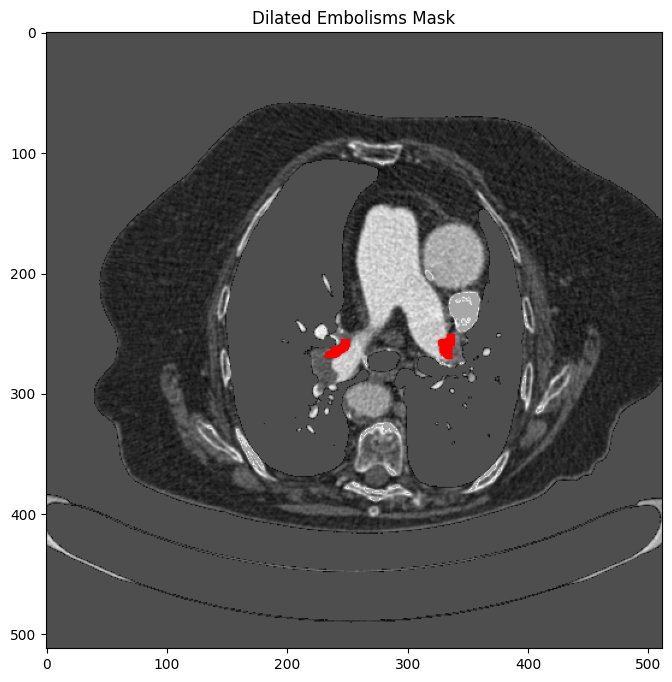

In [50]:
slice_copy_2 = slice_340.copy()
slice_rgb = cv2.cvtColor(slice_copy_2, cv2.COLOR_GRAY2RGB)

color = (255, 0, 0)  # BGR format (red)

# Applying the color to the corresponding pixel in the original slice
slice_rgb[dilated_embolisms_mask != 0] = color

plt.figure(figsize=(8, 8))
plt.imshow(slice_rgb, cmap='gray')
plt.title('Dilated Embolisms Mask')
plt.show()

### Attempt 2: to find the embolisms on the central aorta
#### Rejected this method due to detecting the outline (gray-->black) of the central aorta

#### Edge detection

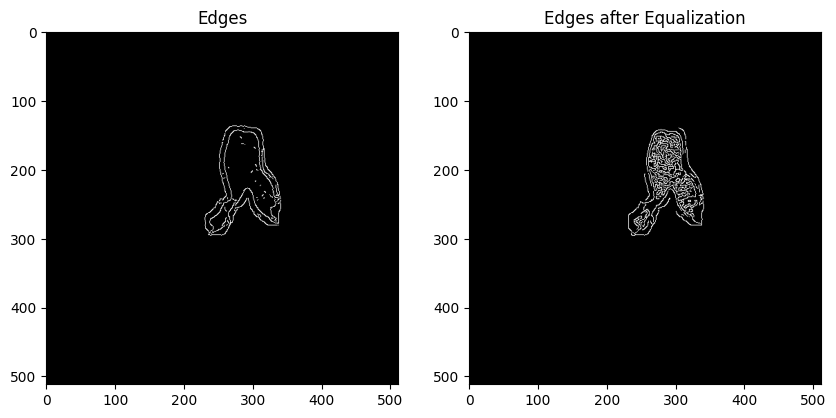

In [37]:
equal_central_aorta = cv2.equalizeHist(blurred_central_aorta)
edges = cv2.Canny(equal_central_aorta, 100, 150)
edges_no_equal = cv2.Canny(blurred_central_aorta, 100, 80)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edges_no_equal, cmap='gray')
plt.title('Edges')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges after Equalization')
plt.show()

# Final Process
## Coloring the embolism

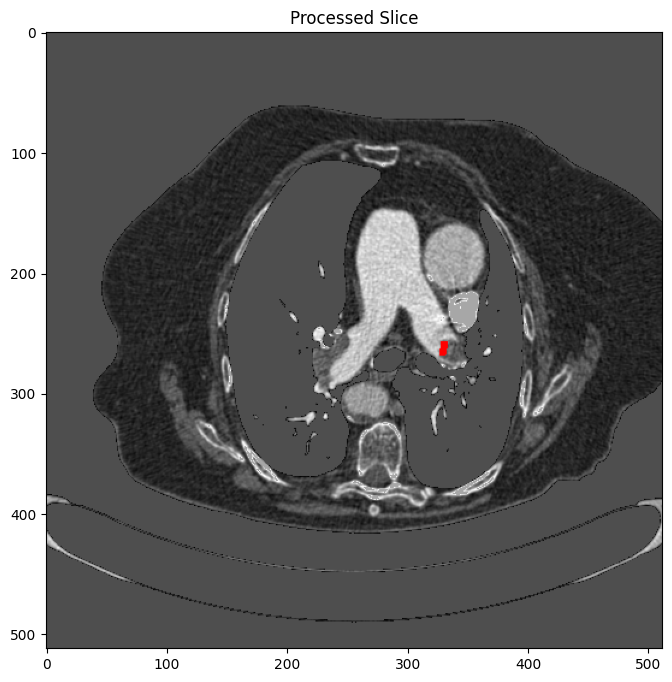

In [58]:
patient_number = '006'
slice_n = 346

slice = cv2.imread(f'patient_{patient_number}/slice_{slice_n}.png',0)

# Creating copies for later use
slice_copy_1 = slice.copy()
slice_copy_2 = slice.copy()

##############################################
### Mapping the central aorta in the slice ###

## 'Cropping' the slice 
## to look for the central aorta more efficiently

# Defining where the 'cropped' slice should start and end
start = 0.25
end = 0.75

# Defining the corners of the 'cropped' slice
upper_left = [int(slice.shape[0]*(start)), int(slice.shape[1]*(start))]
upper_right = [int(slice.shape[0]*end), int(slice.shape[1]*(start))]
lower_left = [int(slice.shape[0]*(start)), int(slice.shape[1]*(end-0.15))]
lower_right = [int(slice.shape[0]*end),int(slice.shape[1]*(end-0.15))]

for x in range(slice.shape[0]):
    for y in range(slice.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            slice[x,y] = 0

## Applying binary threshold to the cropped slice
## to remove the background

_, slice_binary =cv2.threshold(slice,115,255,cv2.THRESH_BINARY)


## Applying connected components analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(slice_binary)

# The background is the 1st and largest component
# hence from stats the 1st compenent is excluded
# The np.argmax() looks for the index of the largest component excluding the background
# Therefore the largest component index from stats would be the above +1
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1

# Creating a binary mask of the largest component
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

## Eroding the largest component

# The largest component acquired from above
# could contain the ascending thoracic aorta (not needed)
# along with the central aorta (need)
# Eroding the component 
# and applying another connected components analysis
# creates a mask of the central aorta

kernel = np.ones((3, 3), np.uint8)

eroded_component = cv2.erode(largest_component_mask, kernel, iterations=2)

## Connected components analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_component)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

### Central aorta acquired ###
#################################################
### Mapping the embolism on the central aorta ###


## 'Cropping' the component
## to keep the bottom half of the central aorta

# There is a need to dilate the component to include the embolism
# that exist on the bottom half of the central aorta.
# By cropping the component first
# the dilation has an effect on the bottom half only.

# 'Cropping' the component up from x = 0 up to x = middle of component
for x in range(0,stats[largest_component_index][1] + int(stats[largest_component_index][3]/2)):
    largest_component_mask[x,:] = 0

## Dilating to include the embolism
dilated_component = cv2.dilate(largest_component_mask, kernel, iterations=6)


## Masking the central aorta and its embolism
slice_copy_1[dilated_component == 0] = 0

## Bluring the central aorta and its embolism
blurred_aorta = cv2.GaussianBlur(slice_copy_1,(5,5),0)

## to use a more effective band thresholding on the embolism
## and create a mask containg the embolisms
embolism_mask = cv2.inRange(blurred_aorta, 90, 120)

## Eroding to remove small particles around the embolism
## that went through the band thresholding
eroded_embolism_component = cv2.erode(embolism_mask, kernel, iterations=1)

## Connected components analysis
## to keep the largest component
## that is the embolism
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_embolism_component)
largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA]) + 1
embolism_mask = (labels == largest_component_index).astype(np.uint8) * 255

## Dilating the embolisk mask
## to reverse the previous erosion
embolism_mask = cv2.dilate(embolism_mask, kernel, iterations=2)

### Embolism Acquired ###
#############################
### Coloring the embolism ###

## On a RGB version of the slice
slice_rgb = cv2.cvtColor(slice_copy_2, cv2.COLOR_GRAY2RGB)

## Using red color
color = (255, 0, 0)

# Applying the color to the corresponding pixel in the original image
slice_rgb[embolism_mask != 0] = color

##### Plotting the colored/processed slice #####
plt.figure(figsize=(8, 8))
plt.imshow(slice_rgb, cmap='gray')
plt.title('Processed Slice')
plt.show()